In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import os
import tiktoken

from code_editing.load_data.load_data_from_hf import load_repos
from code_editing.utils.git_utils import get_repo_spec_content_on_commit

%load_ext autoreload
%autoreload 2

## EDA
Simple analysis of the [JetBrains-Research/lca-code-editing](https://huggingface.co/datasets/JetBrains-Research/lca-code-editing) dataset.
- Message length per modification
- Files count per modification
- File length per diff (normal/tokenized)
- Diff length per diff (normal/tokenized)
- Context size per modification (normal/tokenized). Here context means: the files mentioned in the ground truth modification

See results at the end

In [2]:
cache_dir = os.path.join(os.getcwd(), '..', '..', '..', 'hf_cache')
data_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data')

tokenizer = tiktoken.encoding_for_model('gpt-4')

In [3]:
# Downloading repos if not downloaded
if not os.listdir(data_dir):
    print("Downloading Repos...")
    load_repos(
        "JetBrains-Research/lca-code-editing",
        data_dir,
        cache_dir
    )

In [4]:
dataset = load_dataset("JetBrains-Research/lca-code-editing", 'commitchronicle-py-long', split='test', cache_dir=cache_dir)

In [5]:
dataset

Dataset({
    features: ['hash', 'repo', 'date', 'license', 'message', 'mods'],
    num_rows: 119
})

In [6]:
# Convert the dataset into a dataframe for easier manipulation
df = pd.DataFrame(dataset)
df.head()

,hash,repo,date,license,message,mods
0,c27fd80c76b03bf187fa98029e2edb151644903a,burnysc2/python-sc2,None,None,Add different functions to print debug text\nA...,"{'diff': [{'change_type': 'MODIFY', 'new_path'..."
1,7b2e711c738b864e4e0b7c35257225fb23cfa15d,rqlite/rqlite,None,None,"Remove constraint check\nIt's too clever, and ...","{'diff': [{'change_type': 'MODIFY', 'new_path'..."
2,dad51485282b6e05c4993b0733bd54aa3c0bacef,cupy/cupy,None,None,"Use ""import numpy as np"" in the array_api subm...","{'diff': [{'change_type': 'MODIFY', 'new_path'..."
3,0da4b09082036d2c62a638d751b660a75e543bc9,cupy/cupy,None,None,Add an explanatory docstring to _array_api/__i...,"{'diff': [{'change_type': 'MODIFY', 'new_path'..."
4,76eb888612183768d9e1b0c818fcf5416c5f28c7,cupy/cupy,None,None,Use _implementation on all functions that have...,"{'diff': [{'change_type': 'MODIFY', 'new_path'..."


In [7]:
df.describe()

,hash,repo,date,license,message,mods
count,119,119,0,0,119,119
unique,119,39,0,0,119,119
top,c27fd80c76b03bf187fa98029e2edb151644903a,mesonbuild/meson,NaN,NaN,Add different functions to print debug text\nA...,"{'diff': [{'change_type': 'MODIFY', 'new_path'..."
freq,1,26,NaN,NaN,1,1


In [8]:
df['message'].str.len().describe()

count    119.000000
mean     186.000000
std       67.436097
min       74.000000
25%      127.500000
50%      177.000000
75%      227.000000
max      349.000000
Name: message, dtype: float64

In [9]:
mods = dataset['mods']
diffs = []
for mod in mods:
    diffs += mod['diff']

In [10]:
diffs = pd.DataFrame(diffs)
diffs.head()

,change_type,new_path,old_path,diff
0,MODIFY,sc2/client.py,sc2/client.py,"@@ -29,6 +29,10 @@ class Client(Protocol):\nsu..."
1,MODIFY,system_test/full_system_test.py,system_test/full_system_test.py,"@@ -136,7 +136,7 @@ class Node(object):\nr.rai..."
2,MODIFY,numpy/_array_api/_creation_functions.py,numpy/_array_api/_creation_functions.py,"+import numpy as np\n+\ndef arange(start, /, *..."
3,MODIFY,numpy/_array_api/_elementwise_functions.py,numpy/_array_api/_elementwise_functions.py,"+import numpy as np\n+\ndef abs(x, /):\n- from..."
4,MODIFY,numpy/_array_api/_linear_algebra_functions.py,numpy/_array_api/_linear_algebra_functions.py,+import numpy as np\n+\n# def cholesky():\n-# ...


In [11]:
diffs['change_type'].value_counts()

change_type
MODIFY    445
Name: count, dtype: int64

In [12]:
diff_len = diffs['diff'].str.len()

In [13]:
def myplot(dataframe):
    dataframe.hist(bins=50)
    plt.axvline(dataframe.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean {dataframe.mean().round(2)}')
    plt.axvline(dataframe.median(), color='r', linestyle='dashed', linewidth=1, label=f'Median {dataframe.median().round(2)}')
    plt.legend()

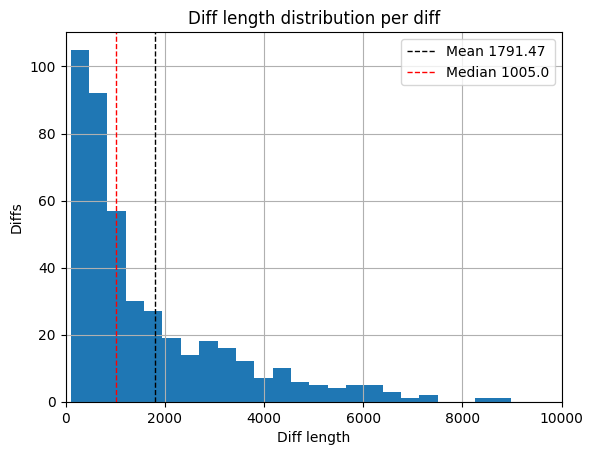

count      445.000000
mean      1791.471910
std       2099.557275
min        102.000000
25%        495.000000
50%       1005.000000
75%       2349.000000
max      18606.000000
Name: diff, dtype: float64

In [14]:
myplot(diff_len)
plt.ylabel('Diffs')
plt.xlabel('Diff length')
plt.title('Diff length distribution per diff')
plt.xlim(0, 10000)
plt.show()
diff_len.describe()

In [15]:
tokenized_diffs = tokenizer.encode_batch(diffs['diff'])
tokenized_diff_len = [len(x) for x in tokenized_diffs]
tokenized_diff_len = pd.Series(tokenized_diff_len)

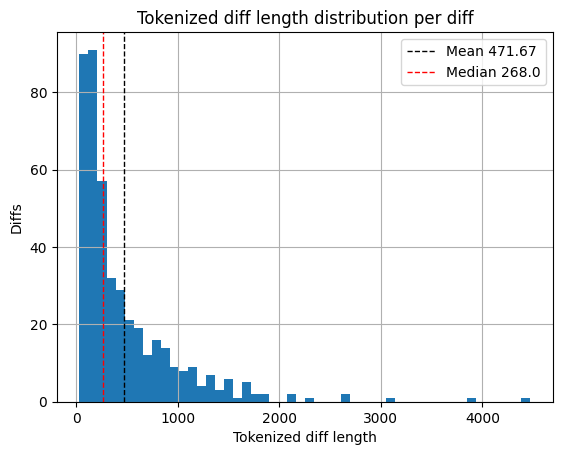

count     445.000000
mean      471.671910
std       530.553994
min        32.000000
25%       132.000000
50%       268.000000
75%       622.000000
max      4473.000000
dtype: float64

In [16]:
myplot(tokenized_diff_len)
plt.ylabel('Diffs')
plt.xlabel('Tokenized diff length')
plt.title('Tokenized diff length distribution per diff')
plt.show()
tokenized_diff_len.describe()

In [17]:
file_contents = []
nums = []

for commit_sha, repo, mod, idx in zip(df['hash'], df['repo'], df['mods'], df.index):
    files = [file['new_path'] for file in mod['diff']]
    res = get_repo_spec_content_on_commit(repo, commit_sha, files, data_dir)
    file_contents += res.values()
    nums += [idx] * len(res)

Can not read file with ext docs/autostarting.md. Replace with empty string... 'charmap' codec can't decode byte 0x8f in position 1021: character maps to <undefined>
Can not read file with ext CHANGES.rst. Replace with empty string... 'charmap' codec can't decode byte 0x8d in position 102367: character maps to <undefined>
Can not read file with ext core/eolearn/core/eoexecution.py. Replace with empty string... 'charmap' codec can't decode byte 0x8d in position 425: character maps to <undefined>
Can not read file with ext core/eolearn/core/utilities.py. Replace with empty string... 'charmap' codec can't decode byte 0x8d in position 249: character maps to <undefined>
Can not read file with ext core/eolearn/tests/test_eoexecutor.py. Replace with empty string... 'charmap' codec can't decode byte 0x8d in position 69: character maps to <undefined>
Can not read file with ext python/fledge/services/core/server.py. Replace with empty string... 'charmap' codec can't decode byte 0x9d in position 1

In [18]:
diffs['file_content'] = file_contents
diffs['commit_num'] = nums

In [19]:
file_counts = diffs.groupby('commit_num')['file_content'].count()

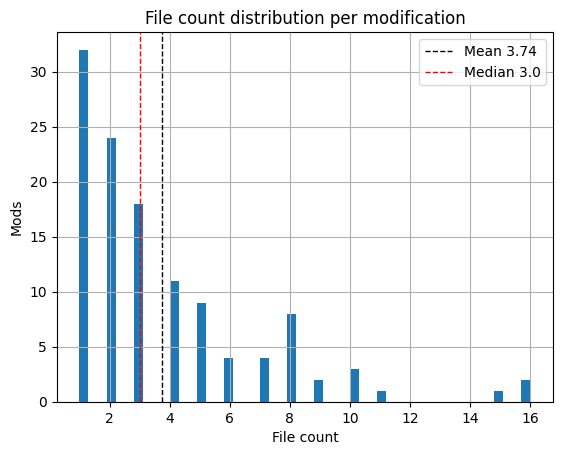

count    119.000000
mean       3.739496
std        3.187534
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       16.000000
Name: file_content, dtype: float64

In [20]:
myplot(file_counts)
plt.ylabel('Mods')
plt.xlabel('File count')
plt.title('File count distribution per modification')
plt.show()
file_counts.describe()

In [21]:
file_lengths = diffs['file_content'].str.len()

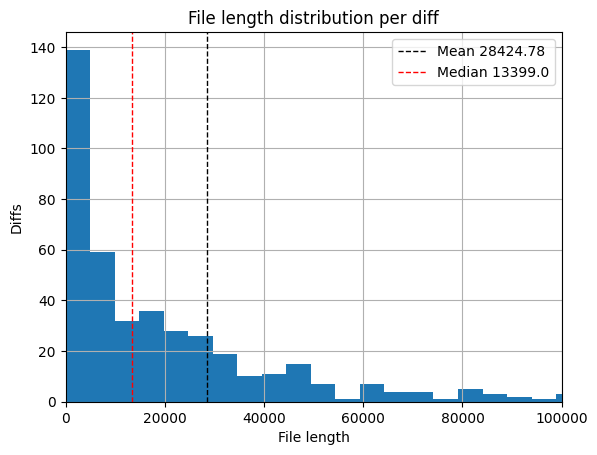

count       445.000000
mean      28424.775281
std       39817.168211
min           0.000000
25%        3738.000000
50%       13399.000000
75%       34178.000000
max      247197.000000
Name: file_content, dtype: float64

In [22]:
myplot(file_lengths)
plt.ylabel('Diffs')
plt.xlabel('File length')
plt.title('File length distribution per diff')
plt.xlim(0, 1e5)
plt.show()
file_lengths.describe()

In [23]:
tokenized_file_contents = tokenizer.encode_batch(file_contents)
tokenized_file_lengths = [len(x) for x in tokenized_file_contents]
tokenized_file_lengths = pd.Series(tokenized_file_lengths)

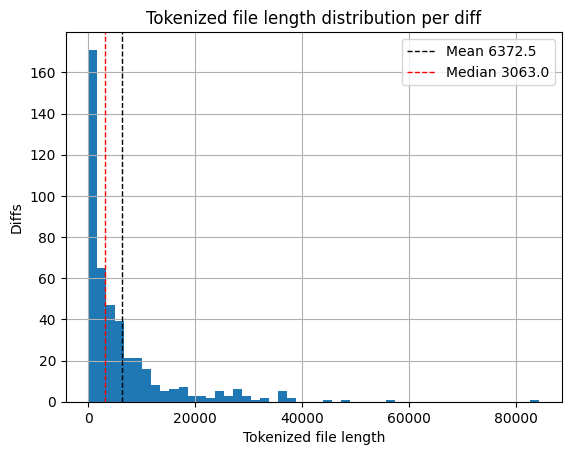

count      445.000000
mean      6372.496629
std       9318.693044
min          0.000000
25%        858.000000
50%       3063.000000
75%       7656.000000
max      84336.000000
dtype: float64

In [24]:
myplot(tokenized_file_lengths)
plt.ylabel('Diffs')
plt.xlabel('Tokenized file length')
plt.title('Tokenized file length distribution per diff')
plt.show()
tokenized_file_lengths.describe()

In [25]:
context_len = diffs.groupby('commit_num')['file_content'].sum().str.len()

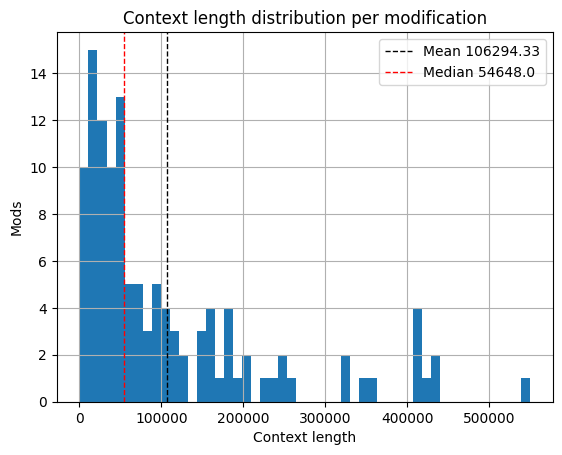

count       119.000000
mean     106294.327731
std      119274.881124
min           0.000000
25%       26552.000000
50%       54648.000000
75%      148807.000000
max      550532.000000
Name: file_content, dtype: float64

In [26]:
myplot(context_len)
plt.ylabel('Mods')
plt.xlabel('Context length')
plt.title('Context length distribution per modification')
plt.show()
context_len.describe()

In [27]:
diffs['tokenized_file_tokens'] = tokenized_file_lengths
tokenized_context_len = diffs.groupby('commit_num')['tokenized_file_tokens'].sum()

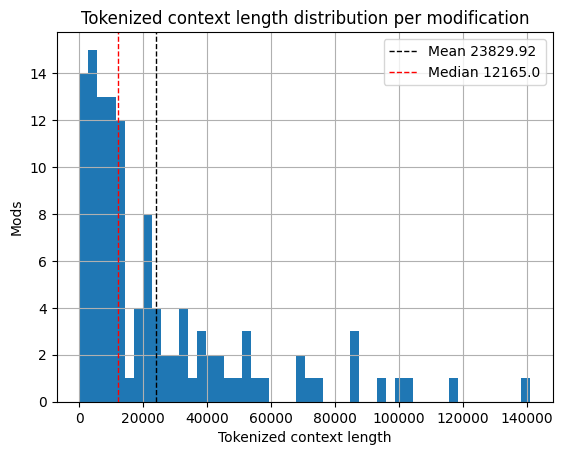

count       119.000000
mean      23829.924370
std       27568.474744
min           0.000000
25%        5921.500000
50%       12165.000000
75%       32716.000000
max      141172.000000
Name: tokenized_file_tokens, dtype: float64

In [28]:
myplot(tokenized_context_len)
plt.ylabel('Mods')
plt.xlabel('Tokenized context length')
plt.title('Tokenized context length distribution per modification')
plt.show()
tokenized_context_len.describe()

## Results
- Message length per modification : **avg=186 chars** (basically negligible)
- Files count per modification : **avg=3.7**
- File length per diff (normal/tokenized) : **avg=28k chars**, **6k tokens**
- Diff length per diff (normal/tokenized) : **avg=1k chars**, **260 tokens**
- Context size per modification (normal/tokenized) : **avg=106k chars**, **24k tokens**

## Observations
- Average context doesn't fit into 16k tokens threshold :(
- Trivial truncation might eat up the relevant code.
- There are very few relevant files for a user instruction. In a large project, localization is very important.
- Diffs themselves are pretty short. The model must be very precise.